# 4.1 Corner detection and description. Harris and NCC

As you are learning throughout this book, images are highly valuable sources of information about the environment. That is why the use of cameras is becoming mainstream in a wider and wider set of real world applications such as robotics, autonomous cars, security, augmented and virtual reality, industrial inspection, etc. As you also know, images must be processed in order to obtain (compact) information about their content. For example, in the previous chapter you learned how to detect edges in an image, which give us valuable information about the contours of the objects in the scene. 

In general, there exist different types of elements of interest that can be extracted from the images such as *corners*, *blobs*, *edges*, etc., each of them with different properties. These elements are collectively called **image features**. In this chapter we will address one of the most common approaches for extracting information from images, namely **keypoint detection** (i.e. finding *interesting* pixels, or points, in the image). The term *interesting* would depend on the application.

In this first notebook we will focus on detecting (and describing) **corners**: image points with high variation of intensity in two spatial directions. Concretely, we will cover corner detection using the well-known and widely used **Harris corner detector** (<a href="#411">section 4.1.1</a>). 

It is important to remark that the output of such detector are just the **positions** of the corners in the images (that's the purpose of a **detector**, actually). So, in order to be able to distinguish between different corners, we have to incorporate some kind of information about the *appearance* of the keypoint, which will be useful to match corresponding corners in different images. This is called the **description** of the corner. In this sense, we are going to explore how to use a patch around the keypoint as the descriptor, and employ the so-called **Normalized Cross-Correlation** (NCC) to find such matches (<a href="#412">section 4.1.2</a>). Finally, we will put these techniques to work together in <a href="#413">section 4.1.3</a>.

## Problem context - Image stitching

Image stitching or photo stitching is the process of combining multiple photographic images with overlapping fields of view to produce a segmented panorama or high-resolution image:

<center><img src="./images/stitching.jpg" width="600"></center>

<center><i>Fig 1. Example of panorama built using image stitching.</i><br /><br /></center>


Feature detection is necessary to find correspondences between images. Robust correspondences are required in order to estimate the necessary transformation to align an image with the image it is being composited on. 

Our task in this notebook is to develop the first step in this process. **This lies in developing a robust point matching between overlapping images**.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
images_path = './images/'

### Initial data

Let's start by **displaying our testing image** `car.jpeg` in the RGB color space. This is the image that we are going to use to familiarize with the concepts behind the Harris corner detector. Remember that by default OpenCV reads the image in BGR mode, so you'll have to convert it.

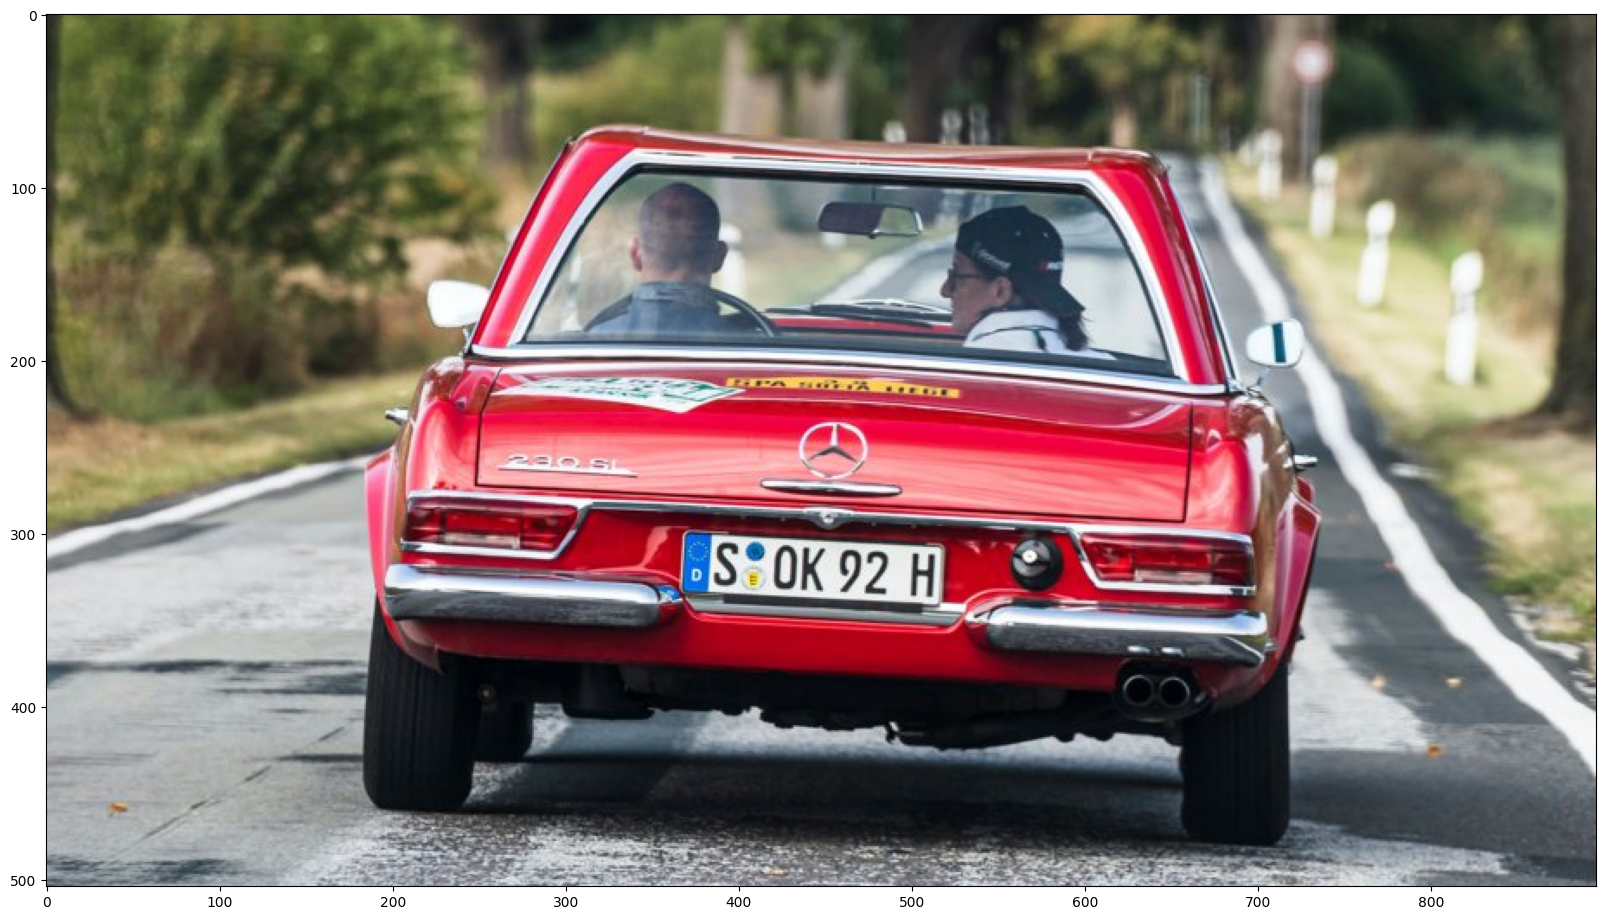

In [2]:
# Read 'car.jpeg' image, convert to RGB and display it
# Write your code here!

# Read image
image = cv2.imread(images_path + 'car.jpeg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Show it
plt.imshow(image);

## 4.1.1 Harris corner detector <a id="411" />

The **Harris detector** permits us to **detect corners** in an image. Recall that a corner is a point with high variation of intensity in 2 spatial directions:

<center><img src="./images/corners.png"  width="500">
    <br/ ><i>Fig 2. Illustrative example of the relation between image derivatives and different region types.</i></center>
   $\\[5pt]$

It has a number of appealing features:
- **Simple and efficient implementation**.
- **Robustness to noise**, since it considers the application of smoothing techniques. 
- It exhibits **invariance to**:
  - **Rotation**: uses eigenvectors.
  - **Brightness** (partially to contrast): uses derivatives.

Unfortunately **it's not invariant to scale**. 

The idea behind the Harris detector is to look for that high variations of intensity in 2 spatial directions in the image. For that, let's consider a grayscale image $I$. Then, a window $w(x,y)$ with displacements $u$ in the x direction and $v$ in the y one is used to calculate variations of intensity:

$$E_{x_0y_0}(u,v) = \sum_{x,y} w(x,y)[\underbrace{I(x+u,y+v)}_\text{Image shifted u,v}-\underbrace{I(x,y)}_{Image}]^2$$

where:
 - $E_{x_0y_0}(u,v)$ represents the computed intensity variation at pixel $[x_0,y_0]$ with the image shifted $(u,v)$,
 - $x$ and $y$ iterate over all the columns and rows of the image $I$,
 - $w(x,y)$ is the weighting window centered at position $(x_0,y_0)$,
 - $I(x,y)$ is the pixel intensity at $(x,y)$, and
 - $I(x+u,y+v)$ is the pixel intensity at the moved window $(x+u,y+v)$

The weighting window $w(x,y)$ typically is boolean (1 inside, 0 outside) or Gaussian, performing a Gaussian weighting. Thus, windows with large variations in intensity are good candidates for containing corners. This way, we have to maximize the previous equation, concretely the second term:

$$E(u,v) = \sum_{x,y} [I(x+u,y+v)-I(x,y)]^2$$

Using the Taylor expansion (first order Taylor approximation) it is written as:

$$E(u,v)= \sum_{x,y}[I(x,y) + uI_x + vI_y - I(x,y)]^2$$

where $I_x$ and $I_y$ are the image derivatives at (x,y) along the x and y axis, respectively.

Notice that the first and the last terms cancel out. Expanding the equation:

$$E(u,v) = \sum_{x,y} u^2I_x^2 + v^2I_y^2 + 2uvI_xI_y$$

Which can be expressed in matrix form as:

$$
E(u,v) 
\approx 
\begin{bmatrix}u & v\end{bmatrix}\underbrace{\left(\sum_{x,y} w(x,y) 
\begin{bmatrix}
I_x^2 & I_xI_y \\
I_x I_y & I_y^2 
\end{bmatrix}
\right)}_{M}
\begin{bmatrix}
u \\ v
\end{bmatrix}
$$

$$
E(u,v) 
\approx 
\begin{bmatrix}u & v\end{bmatrix} M
\begin{bmatrix}
u \\ v
\end{bmatrix}
$$

Recall that the matrix $\mathbf{M}$ is computed for each pixel in the image, and it allows us to differentiate between pixels that are corners and pixels that are not. That matrix encompasses information about how the image intensity spatially changes in the surroundings or neighborhood of such pixel (the window). Therefore, it is not strange that image derivatives (e.g. Sobel) are involved in the building of $\mathbf{M}$. We previously used them to detect edges, and a corner is a point where two edges make contact!

The following image illustrates some examples of $M$ computation and how they relate to the image derivatives.

<center><img src="./images/harris_eigen.PNG" width="600"><br />
<i>Fig 3. Different examples of pixels along with their window, their matrix $M$ and their derivative direction.</i></center>$\\[5pt]$

### Rotation invariance

Notice that the $\mathbf{M}$ matrix takes different values depending on the edges orientation, so the Harris operator would not be invariant to orientation. But... *here comes the magic!* We can extract from $\mathbf{M}$ the direction and strength of the intensity variation by **computing its eigenvectors $(\mathbf{v}_1,\mathbf{v}_2)$ and eigenvalues $(\lambda_1, \lambda_2)$**. This is done by considering a new reference frame at each image point, oriented along the direction of the highest average intensity derivative. 

For that, we diagonalize $\mathbf{M}$ and consider a new eigenvector base $v_1$, $v_2$. That is:

$$M=VDV^T,  \ \ \ \ D = \begin{bmatrix} \lambda_1 & 0 \\ 0 & \lambda_2 \end{bmatrix}, \ \ \ \  V = \begin{bmatrix} v_{1x} & v_{1y} \\ v_{2x} & v_{2y}\end{bmatrix}$$

so: 

$$
E(u,v) 
\approx 
\begin{bmatrix}u & v\end{bmatrix} M
\begin{bmatrix}
u \\ v
\end{bmatrix}
=
\begin{bmatrix}u & v\end{bmatrix} VDV^T
\begin{bmatrix}
u \\ v
\end{bmatrix}
$$

The largest eigenvalue indicates how strong is the change in intensity along the principal direction of the change, while the smallest one does the same for its perpendicular direction. This way, we can find three different scenarios: 

- if both eigenvalues are large, it indicates that there is a large change in both directions and hence, the pixel is a good corner candidate. 
- If only just one eigenvalue is large, then we are facing an edge and, 
- finally, both eigenvalues are small in flat, textureless regions.

<center><img src="./images/harris_eigenvalues_map.PNG" width="350">
    <br > <i>Fig 4. Relation between eigenvaules' and region types.</i></center>


### The R variable

However, **computing eigenvalues and eigenvectors is a costly process**, and we need to do it for each pixel in the image! Thus, Harris proposed an alternative metric to get the same information. It is based on the definition of a scalar variable $R$ that indexes the same domain:

$$R = \underbrace{\lambda_1 \lambda_2}_\text{Determinant} - k (\underbrace{\lambda_1+\lambda_2}_\text{Trace})^2$$

and given that the trace and the determinant of $\mathbf{M}$ and $\mathbf{D}$ are the same, then:

$$R = \text{det}(\mathbf{M}) - k (\text{trace}(\mathbf{M}))^2$$

so **there is no need to compute the eigenvalues!** In these equations, $k$ is an empirically determined constant value in the range $[0.04,0.06]$.

This $R$ value is interpreted as follows:
- $R$ is large and positive at corners,
- $R$ is negative at edges, and
- $R$ is small at flat regions. 

### Robustness to noise

The window $w$ has another interesting role in the Harris detector: it **smooths** the computed derivatives, hence providing robustness against image noise. If the window is binary, then it performs average smoothing, and if it is Gaussian, it applies the smoothing technique with the same name. 

So, up to this point, you already know the tools that we are using: 
- a border detector (e.g. Sobel), and 
- a Gaussian filter/Average smoothing. 

Here we can see an example of the derivatives of the image and their smoothed versions:$\\[5pt]$

<center><img src="./images/harris.png"  width="600">
    <br/><i>Fig 5. Two image derivatives (rows and columns) and their squared, multiplied and smoothed versions.</i></center>$\\[5pt]$

### The Harris detector algorithm

To summarize, the steps of the Harris detector algorithm are as follow:

1. Compute the image derivatives $I_x$ and $I_y$ (*e.g.* using Sobel).
2. Apply a gaussian smoothing/neighbor averaging to $(I_x)^2$, $(I_y)^2$, and $I_x I_y$. These two first steps compute the $\mathbf{M}$ matrix for all pixels in the image.
3. Compute the matrix/image $\mathbf{R}$ from the formula involving the trace and determinant of $\mathbf{M}$.
4. Find pixels where $\mathbf{R}$ is high ($\mathbf{R}>\text{threshold}$).
5. Select local maxima to avoid multiple responses. 

Let's implement it!

#### <font color="orange">OpenCV pill</font>

In practice, the Harris detector is already implemented in OpenCV with the method [`cv2.cornerHarris()`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345), which takes as inputs:

- **src**: input grayscale image
- **block_size**: neighborhood (window) size
- **ksize**: size of the Sobel kernel (an odd value)
- **k**: the previously mentioned empiric constant, usually in the range $[0.04,0.06]$.

and returns the $R$ value at each pixel.

### **<span style="color:green"><b><i>ASSIGNMENT 1a: R matrix</i></b></span>**

Compute the $\mathbf{R}$ matrix of the previous `car.jpeg` image using the Harris detector from OpenCV and display it. Take into account that the **Harris method** (and most keypoint detectors) **works with the grayscale version of the inputs images**. The color image will be used just for visualization purposes.

In [3]:
# Assignment 1a
# Write your code here!
# Convert to gray
gray = cv2.cvtColor(None, None)

# Size of Sobel kernel
size_sobel = 3

# Empiric constant K
const_k = 0.04

# Size of Gaussian window (in openCV neighbor averaging)
size_window = 3

# Apply Harris
harris = cv2.cornerHarris(None, None, None, None)

# Show R image
plt.imshow(None, None);

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


If you plot the $\mathbf{R}$ matrix, also called response map, you should see an image where borders are black pixels, corners are white ones, and flat surfaces are gray.

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

**It is interesting** to play a bit with the input parameters. Then **answer the following questions**:

- What happens if the size of $W$ is 1?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- What happens if the size of $W$ is large? (*note that `cv2.cornerHarris()` uses neighborhood averaging instead of Gaussian filtering*)
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   

### Thresholding the response map $\mathbf{R}$

The previous code computes the response map $\mathbf{R}$ but, in the end, we need information about which image points contain corners, that is, a binary yes/no response. This is typically done by setting a threshold so pixels with a response higher than it are considered corners.  

### **<span style="color:green"><b><i>ASSIGNMENT 1b: Analyzing $\mathbf{R}$</i></b></span>**

In order to make an informed choice of that threshold, print the maximum and minimum values in the response map $\mathbf{R}$.

In [ ]:
# Assignment 1b
#
# Print max and min values of the R matrix (given)
print("Max: " , None, "\nMin: ", None)

Are those values the same for different images or input parameters?  

**No**, they are not. As they change, it is necessary to define the threshold relative to the maximum value in $\mathbf{R}$ (in this way we skip normalization).  

### **<span style="color:green"><b><i>ASSIGNMENT 1c: Thresholding</i></b></span>**

Use the OpenCV's [`cv2.threshold()`](https://docs.opencv.org/trunk/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57) method to binarize the $\mathbf{R}$ matrix using a threshold that you think is suitable. Then, display the obtained results.

*Hint: For computing the threshold, we'll multiply the maximum value by a scale factor. If you do `1*harris.max()` (a scale factor of 1), only the pixels having a R reponse equal to `harris.max()` will be set to white. If you do `0.5*harris.max()` (a scale factor of 0.5), those having a R response equal or higher than half `harris.max()` will be set to white, and so on!*

In [ ]:
# Assignment 1c
# Define the threshold wrt the maximum value, apply binarization to the image and display the result
# Write your code here!

# Define the threshold wrt the maximum value
threshold = None*harris.max()

# Apply binarization and show the result
_, corners = cv2.threshold(None, None, None, None)
plt.imshow(None, None);

### Non-maximum suppression

The resulting binarized image shows white points where the $\mathbf{R}$ values are over the threshold and black points otherwise. However, around maximum values, there are many points that are close to each other. That is, we are getting multiple responses for the same corner.

The general solution to this is to apply what is called **non-maximum suppression** to those clusters of points, keeping only a point for each of them (remember that this step was also part of the Canny edge detector!).$\\[10pt]$

<center><img src="./images/nonmax.png" width="600"><br />
    <i>Fig 6. An illustrative example of how non-maximum suppression works.</i></center>$\\[5pt]$

To make this easier for you, we provide to you a `nonmaxsuppts()` function with an implementation of the non-maximum suppression step, which finds local maxima as corners within a window. This method returns two lists of numbers with the rows and columns, respectively, of the isolated corners.

In [ ]:
# This method has been provided to you
from scipy import signal
def nonmaxsuppts(cim, radius, thresh):
    """ Binarize and apply non-maximum suppresion.   
    
        Args:
            cim: the harris 'R' image
            radius: the aperture size of local maxima window
            thresh: the threshold value for binarization
                    
        Returns: 
            r, c: two numpy vectors being the row (r) and the column (c) of each keypoint
    """   
    
    rows, cols = np.shape(cim)
    sze = 2 * radius + 1
    mx = signal.order_filter(cim, np.ones([sze, sze]), sze ** 2 - 1)
    bordermask = np.zeros([rows, cols]);
    bordermask[radius:(rows - radius), radius:(cols - radius)] = 1
    cim = np.array(cim)
    r, c = np.where((cim == mx) & (cim > thresh) & (bordermask == 1))
    return r, c

#### <font color="orange">OpenCV pill</font>

In order to represent keypoints, OpenCV defines a set of functions for drawing objects related to feature detection. An example is [`cv2.drawKeypoints()`](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#gab958f8900dd10f14316521c149a60433), which given an image and a list of [`cv2.KeyPoint()`](https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html) objects, it draws them on the output image (third input argument).

Note that this implies the transformation of `r` and `c` to a `cv2.KeyPoint` list. 

*Tip: Have a look at: [rows and columns to KeyPoint list ideas](https://www.programcreek.com/python/example/77058/cv2.KeyPoint)*

### **<span style="color:green"><b><i>ASSIGNMENT 1d: Non-maxima suppression</i></b></span>**

Apply non-maxima suppression to the previous $\mathbf{R}$ image and draw the detected keypoints on the image.

In [ ]:
# Asignment 1d
# Apply non-max suppression to R and display the remaining keypoints on the image
# Write your code here!

# Define the radius of the keypoint neighborhood to be considered
radius_non_maxima = 5

# Apply non maxima supression
r,c = nonmaxsuppts(None, None, threshold)

# Convert coordinates to cv2.KeyPoint list
kps = [cv2.KeyPoint(None, None, None) for i in range(len(r))]

# Draw keypoints
image_corners = np.copy(image)
cv2.drawKeypoints(None, None, None)

# Show image with corners
plt.imshow(image_corners);

## 4.1.2 Keypoint matching through NCC <a id="412" />

One important thing to understand is that after extracting the keypoints, you only obtain information about their position. While this information might be enough for some applications (e.g. counting corners), it does not say much about the keypoints themselves. For example, in applications where you need to match keypoints, that is, identify the correspondence of one keypoint in an image with those in the other one, to know the pixel location is not enough. 

This reveals the need to **describe** such keypoints, and **match** them according to these descriptions. The simplest descriptor is to consider the intensity of the pixels surrounding a keypoint, i.e. to extract **a patch of the image** with the keypoint at its center. But, how to match keypoints according to these patches?

At this point is where the **Normalized Cross-Correlation (NCC)** technique could help. Computing the NCC is similar to applying a convolution, i.e. a sliding window (the image patch, template, or kernel) is applied to an image. Unlike in the convolution case, NCC does not flip the kernel/patch. $\\[5pt]$

<center><img src="./images/ncc_convolution.jpg" width="400"><br />
    <i>Fig 7. Comparison between convolution and CC operations.</i>$\\[5pt]$

Moreover, the *Normalized* in NCC means that the results are normalized in order to be invariant to changes in brightness and contrast of the image $f$ and patch $h$.

$$NCC(x,y) = \sum_{i,j}\hat f (x+i,y+j) \hat h(i,j)$$

where $\hat f$ and $\hat h$ have zero mean and contrast one. Recall that these functions are:
        
$$ \hat{f}(x+i,y+i)=\frac{f(x+i,y+i)-\overline{f}}{||f-\overline{f}||_{w_m(x,y)}}, \, \, 
\hat{h}(x,y)=\frac{h(x,y)-\overline{h}}{||h-\overline{h}||_{w_m(x,y)}}$$

being $\overline{f}$ and $\overline{h}$ the mean brightness of the image patch and the template, respectively, and $||f-\overline{f}||_{w_m(x,y)}$ and $||h-\overline{h}||_{w_m(x,y)}$ their contrast.

The intuition behind this method is that, after applying NCC, **the most similar points to the patch in the image take higher NCC values** (closer to 1). The next cell of code shows two patches from two different images, and a template. Then, it illustrates how correlation and normalized correlation are computed. 

In [ ]:
im_patch_1 = np.array([[220,30,200],[210,205,220],[220,40,230]]);
im_patch_2 = np.array([[210,230,220],[20,215,10],[10,250,30]]);
tempalte = np.array([[255,0,255],[255,255,255],[255,0,255]]);

plt.figure(figsize=(8,4))
plt.subplot(1,3,1), plt.xticks([]), plt.yticks([]) 
plt.title('Patch from image 1')
plt.imshow(im_patch_1, cmap='gray');
plt.subplot(1,3,2), plt.xticks([]), plt.yticks([]) 
plt.title('Patch from image 2')
plt.imshow(im_patch_2, cmap='gray');
plt.subplot(1,3,3)
plt.title('Template'), plt.xticks([]), plt.yticks([]) 
plt.imshow(tempalte, cmap='gray');
plt.show()

# Correlation
corr_1 = np.sum(im_patch_1 * tempalte)
corr_2 = np.sum(im_patch_2 * tempalte)
print('Cross correlation between patch from image 1 and tempalte:', corr_1)
print('Cross correlation between patch from image 2 and tempalte:', corr_2)

# Normalized correlation
im_patch_1_mean = np.mean(im_patch_1)
im_patch_2_mean = np.mean(im_patch_2)
tempalte_mean = np.mean(tempalte)

im_patch_1_contrast = np.sqrt(np.sum((im_patch_1 - im_patch_1_mean)**2))
im_patch_2_contrast = np.sqrt(np.sum((im_patch_2 - im_patch_2_mean)**2))
tempalte_contrast = np.sqrt(np.sum((tempalte - tempalte_mean)**2))

ncc_1 = np.sum(((im_patch_1-im_patch_1_mean)/im_patch_1_contrast)*((tempalte-tempalte_mean)/tempalte_contrast))
ncc_2 = np.sum(((im_patch_2-im_patch_2_mean)/im_patch_2_contrast)*((tempalte-tempalte_mean)/tempalte_contrast))
print('Normalized cross correlation between patch from image 1 and tempalte:', ncc_1)
print('Normalized cross correlation between patch from image 2 and tempalte:', ncc_2)

#### <font color="orange">OpenCV pill</font>

OpenCV implements the function [`cv2.matchTemplate()`](https://docs.opencv.org/master/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be), which takes:
- as first argument an `image`, 
- and applies NCC with the `template` or patch provided as second argument,
- using the method provided by its third argument (use `cv2.TM_CCORR_NORMED`).

That is, the template slides over every pixel in the image and its NCC response is computed, giving a score indicating how much the template looks like the image at that pixel. 

This code will help you to understand how NCC works.   
- **Review it and try to explain what is done here** (you can modify `p_index` and `w_temp` parameters).

In [ ]:
# This snippet has been provided to you. Play with 'p_index' and 'w_temp' values

# Index of the focusing point
p_index = 50

# NCC window aperture
w_temp = 20

# Get the NCC window
p_r, p_c = r[p_index], c[p_index]
template = image[p_r-w_temp:p_r+w_temp+1,p_c-w_temp:p_c+w_temp+1]

# Calculate the NCC image (note the cv2.TM_CCORR_NORMED parameter!)
ncc = cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)

# Search the maximum in NCC
p_x, p_y = p_c, p_r
[max_y, max_x] = np.where(ncc == np.amax(ncc))

# Print some interesting information
print('> Coordinates of [max_y,max_x]:', max_y, max_x)
print('NCC value:', ncc[max_y,max_x])
print('> Other random coordinates. e.g. [100] [300]')
print('NCC value:', ncc[100,300])

# Draw a rectangle in matching points
image_draw = np.copy(image)
ncc_draw = np.copy(ncc)

cv2.rectangle(image_draw,(p_x-w_temp,p_y-w_temp),(p_x+w_temp+1,p_y+w_temp+1),(0,255,0),3)
cv2.rectangle(ncc_draw,(max_x-w_temp,max_y-w_temp),(max_x+w_temp+1,max_y+w_temp+1),0,3)

# Show the original image
plt.subplot(121)
plt.imshow(image_draw)
plt.title('Original image')

# Show the NCC image
plt.subplot(122)
plt.imshow(ncc_draw, cmap='gray')
plt.title('NCC')
plt.show()

As you can see, the patch with the green rectangle in the left image has a maximum NCC value at the black rectangle in the right image. As you can imagine, since the template is extracted from the same image, the NCC value will be 1 at the same exact position (the template and the image at that point are exactly the same!). But this is just an example to illustrate how all this works. 

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Now, **answer the following questions**:

- Describe what variables `p_index` and `w_temp` do.
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- What does the NCC image/response represent?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- What would happen if `template` was taken from a similar (but not the same) image?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    

## 4.1.3 Time to work! Find matches between images with (some) overlapping <a id="413" />

It is time to apply what have been learned during this notebook. Coming back to image stitching, **you are asked** to compute matches between two images with overlapping areas. The images are `park_l.jpeg` (left) and `park_r.jpeg` (right).

**For that, you should use the Harris corner detector and the NCC descriptor**. Also, you will have to draw the keypoints and the matches using [`cv2.drawMatches()`](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#ga7421b3941617d7267e3f2311582f49e1), which takes two images, two lists of `cv2.KeyPoint` objects and a list of [`cv2.DMatch`](https://docs.opencv.org/3.4/d4/de0/classcv_1_1DMatch.html) objects as input. To create a `cv2.DMatch` object it is used `cv2.DMatch(idx_l, idx_r,1)`, being `idx_l` and `idx_r` the indices of the matching keypoints (in the left and right lists of keypoints, respectively).

*Tip: [Drawing functions documentation](https://docs.opencv.org/master/d4/d5d/group__features2d__draw.html)* 

Results should look like this (output of [`cv2.drawMatches()`](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#ga7421b3941617d7267e3f2311582f49e1)):

<img src="./images/index.png" width="1000">

### **<span style="color:green"><b><i>ASSIGNMENT 2a: First, detect keypoints with Harris</i></b></span>**

- Use the Harris corner detector to get the keypoints of both grayscale images (do not forget to apply non-max suppression to the resulting $\mathbf{R}$ image!)
- Convert them to two lists of `cv2.KeyPoint` objects.

In [ ]:
# Assignment 2a
# Detect Harris keypoints in the images and convert them to a 'cv2.Keypoint' list

# Write your code here!

# Size of Sobel kernel
size_sobel = 3

# Size of Gaussian window (in openCV neighbor averaging)
size_window = 2

# Empiric constant K
const_k = 0.05

# Read images
image_l = cv2.imread(images_path + 'park_l.jpeg')
image_r = cv2.imread(images_path + 'park_r.jpeg')
image_l = cv2.cvtColor(image_l,cv2.COLOR_BGR2RGB)
image_r = cv2.cvtColor(image_r,cv2.COLOR_BGR2RGB)

# Get gray images
image_l_gray = cv2.cvtColor(None, None)
image_r_gray = cv2.cvtColor(None, None)

# Compute corners
harris_l = cv2.cornerHarris(None, None, None, None)
harris_r = cv2.cornerHarris(None, None, None, None)

# For non-max-supp
radius_non_maxima = 3

# Apply non maximum supression
r_l,c_l = nonmaxsuppts(None, None, 0.1*harris_l.max())
r_r,c_r = nonmaxsuppts(None, None, 0.1*harris_r.max())

# Convert coordinates to cv2.KeyPoint list
kps_l = [cv2.KeyPoint(None, None, None) for i in range(len(r_l))]
kps_r = [cv2.KeyPoint(None, None, None) for i in range(len(r_r))]

### **<span style="color:green"><b><i>ASSIGNMENT 2b: Avoiding issues</i></b></span>**

Now, we will address an intermediate step to avoid future issues. As we will need to extract a template around the keypoints and it might happen that those can be detected too close to the border (e.g. a keypoint found at (0,0)), we will add a *padding* to the image using the OpenCV's method
[`cv2.copyMakeBorder()`](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=copymakeborder#void%20copyMakeBorder(InputArray%20src,%20OutputArray%20dst,%20int%20top,%20int%20bottom,%20int%20left,%20int%20right,%20int%20borderType,%20const%20Scalar&%20value)) (`cv2.BORDER_REFLECT` is the best padding option in this case)

In [ ]:
# Assignment 2b
# Add padding to the images
# Write your code here!

# Aperture size of the NCC window
w_temp = 20

# Apply border reflect padding to images
image_l_pad = cv2.copyMakeBorder(None, w_temp, w_temp, w_temp, w_temp, None)
image_r_pad = cv2.copyMakeBorder(None, w_temp, w_temp, w_temp, w_temp, None)

### **<span style="color:green"><b><i>ASSIGNMENT 2c: Matching</i></b></span>**

And finally:
- For every $i$-th keypoint in the left image:
    1. Take a template around that point.
    - Compute the NCC value using that template with **the whole right image**, as in the provided example.
    - Since we want to retrieve true matches, find **the maximum NCC value** at the positions of the keypoints in the right image.
    - If the maximum NCC value (for a $j$ keypoint in the right image) is greater than a certain threshold (e.g. 0.95, but tune it for robustness), create a `cv2.DMatch` object with the indexes $(i,j)$ of the keypoints and add it to a list of matches.
- Once all matches are defined, use the `cv2.drawMatches()` method to display the resulting color image with the matches.

*Tip: When displaying the resulting image, it is preferable to make a copy of the original color image and use it as the output image for the `cv2.drawMatches()` method. This way it keeps the same size as the original one.*

Be careful with the number of keypoints detected, as **it could take a time to process all of them!**

In [ ]:
a = np.array([1,2,3])
b = np.array([1,2,4])
c = np.eye(5)
c[2,2] = 3
print(a)
print(b)
print(c)
print(c[a,b])
print(np.where(c[a,b] == 3))
[d] = np.where(c[a,b] == 3)
print(d)

In [ ]:
# Assignment 2c
# Match the keypoints in both images by using NCC, get a 'cv2.DMatch' list and display the matches
# Write your code here!

# Initialize matches list
matches = []

# For each keypoint in left image
for p_index in range(len(r_l)):
    
    # 1. Get the template (note the w_temp offset because of the padding in previous step)
    p_r, p_c = r_l[p_index]+w_temp, c_l[p_index]+w_temp
    template = image_l_pad[p_r-None:p_r+None+1,p_c-None:p_c+None+1]
    
    # 2. Compute NCC of the left keypoint in right image
    ncc = cv2.matchTemplate(None, None, None)

    # 3. Find max value in NCC (only at the right keypoints)
    max_value = np.amax(ncc[None,None])
    
    # 4. If match is good
    if max_value > 0.95:
        # Include in match list
        max_index = np.argmax(None)
        matches.append((p_index, max_index))

# Cast matches list to cv2.DMatch list
matches = np.asarray(matches)
matches = [cv2.DMatch(matches[None,None], matches[None,None],1) for i in range(matches.shape[0])]

# Draw matches
image_matches = np.copy(image_l)
image_matches = cv2.drawMatches(None,None,None,None,None,image_matches)

# And show them
plt.imshow(image_matches);

Great! You have been able to find keypoints in two images and match them! You would probably have found that **not all matches are correct**, and that is normal. Take into account that matching keypoints based on their appearance around a small patch is not really easy for computers (not even for humans!). Of course, there are other methods to describe the keypoints that are more robust, as we will see next.

In deployed applications, this *outliers* (i.e. wrong associations) problem is addressed by implementing certain filters that incorporate more information about the scene.

## Conclusion

This was a hard work, but finally you made it! In this notebook you have learned to:

- detect corners using the Harris detector,
- match corners using image patches and NCC, and
- develop the first steps for an image stitching system.